### Import libraries

In [1]:
import os
import fastbook
from fastbook import *

In [6]:
import matplotlib as mpl, pkgutil, requests, time
from fastai.vision.all import *
from fastdownload import download_url
from pandas.api.types import CategoricalDtype
from scipy.cluster import hierarchy as hc
from io import StringIO, BytesIO
from urllib.error import URLError,HTTPError
from time import sleep


I had to redefine the function that were used in the Course.

In [3]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]


In [12]:
from IPython.display import Image, display

urls = search_images_ddg('bus', max_images=1)

display(Image(url=urls[0]))


- So the function to search on the web for photos is working properly.
- I am going to use 'bus' and 'road' and try to learn a deep learning method fairly easily with fastai python library.

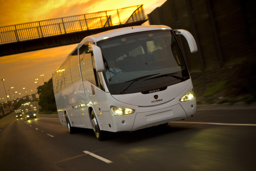

In [5]:
from fastdownload import download_url
keyword = 'bus'
filename = keyword+'.jpg'
urls = search_images_ddg(keyword, max_images=1)
download_url(urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [7]:
categories = 'bus','road'
path = Path(categories[0] + '_or_'+ categories[1])

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)


Removed failed images

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

19

Get a Random sample from the images that were downloaded

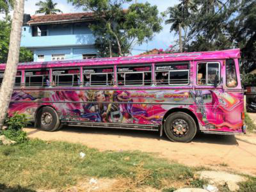

Category:bus


In [33]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

downloaded_imgs = get_image_files(path)
total_imgs = len(downloaded_imgs)
rand = int(np.random.uniform(0,total_imgs))
filename = downloaded_imgs[rand]
im = Image.open(filename)

im.thumbnail((256, 256))
display(im)

print("Category:" + str(downloaded_imgs[rand]).split("/")[1])

In [50]:
categories = 'bus','road'
imgs_category = 0
for i in range(total_imgs): 
    if str(downloaded_imgs[i]).split("/")[1] == categories[0]:
        imgs_category += 1

print("There are " + str(imgs_category)+ " " + categories[0] + " images!")
print(".. and " + str(total_imgs - imgs_category) + " " + categories[1] + " images!")

There are 184 bus images!
.. and 182 road images!


### Run FastAI DataBlock that makes "magic" happen

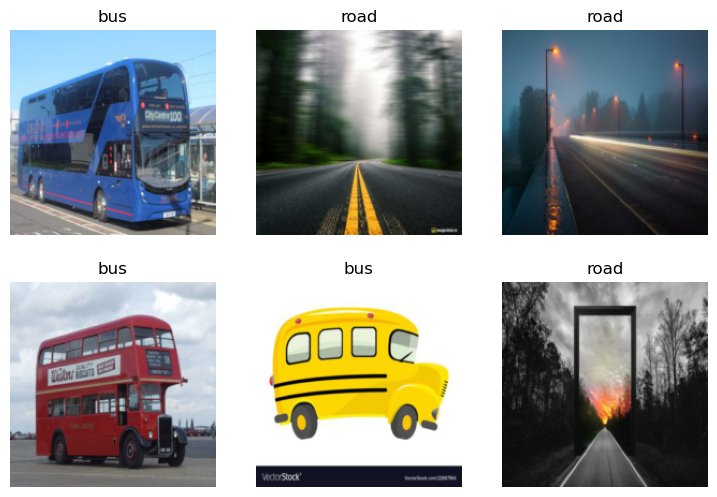

In [36]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6, show=True)


#### Train model with FastAI

In [51]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/ymarca/anaconda3/envs/deeplearning/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,error_rate,time
0,0.883668,0.203929,0.095890,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.053013,0.030921,0.013699,00:32
1,0.038568,0.047885,0.013699,00:31
2,0.026068,0.060127,0.013699,00:31
3,0.024410,0.043484,0.013699,00:31


#### Download new images to test

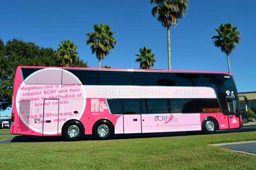

This is a: bus.
Probability it's a bus: 1.0000


In [59]:
test = 'pink_bus'
filename = test + '.jpg'
urls = search_images_ddg(test, max_images=1)
download_url(urls[0], filename, show_progress=False)

im = Image.open(filename)
im.thumbnail((256, 256))
display(im)

cat,_,probs = learn.predict(PILImage.create(filename))
print(f"This is a: {cat}.")
print(f"Probability it's a {cat}: {probs[0]:.4f}")

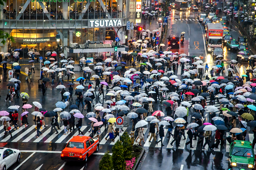

This is a: road.
Probability it's a road: 0.9614


In [69]:
test = 'congested_street'
filename = test + '.jpg'
urls = search_images_ddg(test, max_images=4)
download_url(urls[3], filename, show_progress=False)

im = Image.open(filename)
im.thumbnail((256, 256))
display(im)

cat,_,probs = learn.predict(PILImage.create(filename))
print(f"This is a: {cat}.")
print(f"Probability it's a {cat}: {probs[1]:.4f}")